In [1]:
import pandas as pd
import numpy as np
import os
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
os.chdir('/Users/alexanderhepburn/Documents/MSc Data Science/1 DS Fundamentals/Assignment 2')

# Feature Engineering

In [3]:
attributes = pd.read_csv('data/attributes.csv', index_col=0)
edges = pd.read_csv('data/edges_train.edgelist', names=['node1', 'node2'])
test = pd.read_csv('data/solutionInput.csv')

In [4]:
G = nx.Graph()
G.add_edges_from(edges.values)

In [5]:
print(G)

Graph with 1500 nodes and 6600 edges


Encode 'attributes'

In [6]:
le = LabelEncoder()
attributes['encoded_attr'] = le.fit_transform(attributes['attribute'])


In [7]:
#dummies = pd.get_dummies(attributes.attribute)
#attributes = pd.concat([dummies])
#attributes.drop(attributes.columns[0], axis=1, inplace=True)

In [8]:
attributes

,attribute,encoded_attr
ID,,
0,l,2
1,x,4
2,x,4
3,x,4
4,x,4
...,...,...
1495,l,2
1496,l,2
1497,l,2


This function calculates several features based on each pair of nodes within the network.

In [9]:
def extract_features(node1, node2, G):
    features = []
    # Common neighbors
    common_neighbors = len(list(nx.common_neighbors(G, node1, node2)))
    features.append(common_neighbors)
    
#Jaccard Coefficient
    jaccard_coeff = list(nx.jaccard_coefficient(G, [(node1, node2)]))[0][2]
    features.append(jaccard_coeff)
    
    # Preferential Attachment
    pref_attach = list(nx.preferential_attachment(G, [(node1, node2)]))[0][2]
    features.append(pref_attach)
    
    # Adamic-Adar Index
    adamic_adar = list(nx.adamic_adar_index(G, [(node1, node2)]))[0][2]
    features.append(adamic_adar)
    
    # Shortest Path Distance (if reachable)
    try:
        shortest_path = nx.shortest_path_length(G, source=node1, target=node2)
    except nx.NetworkXNoPath:
        shortest_path = -1
    features.append(shortest_path)
    
    # Node attributes (encoded)
    attr_diff = abs(attributes.loc[node1, 'encoded_attr'] - attributes.loc[node2, 'encoded_attr'])
    features.append(attr_diff)
    
    return features


Using 'extract_features' we can now construct our final X and Y sets.

In [10]:
def create_dataset(G, edges, attributes):
    X = []
    y = []
    
    # Positive samples (existing edges)
    for i, row in edges.iterrows():
        node1, node2 = row['node1'], row['node2']
        X.append(extract_features(node1, node2, G))
        y.append(1)  # Positive label
    
    # Negative samples (non-existing edges)
    non_edges = []
    while len(non_edges) < len(edges):
        node1, node2 = np.random.randint(0, len(attributes), 2)
        if not G.has_edge(node1, node2) and node1 != node2:
            X.append(extract_features(node1, node2, G))
            y.append(0)  # Negative label
            non_edges.append((node1, node2))
    
    return np.array(X), np.array(y)


In [11]:
X, y = create_dataset(G, edges, attributes)

# Principal Component Analysis

In [12]:
# After feature extraction, but before model training:
from sklearn.decomposition import PCA

# Assume X is the feature matrix and y is the label vector from create_dataset function

# Apply PCA to reduce dimensionality
pca = PCA(n_components=4)  # You can change the number of components
X_pca = pca.fit_transform(X)

# Now X_pca is the reduced feature set, and we proceed with training
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)



In [13]:
#X, y = create_dataset(G, edges, attributes)

# Train-test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
X_train

array([[ 1.48681018e+02, -1.64891320e+00, -1.48956269e-01,
        -5.22583954e-01],
       [-1.17322875e+02,  5.87509273e-01,  3.01547003e+00,
        -5.27176859e-01],
       [ 6.78700268e+02, -1.02107494e+00,  8.17548137e-01,
         4.06838050e+00],
       ...,
       [-1.17320566e+02, -2.07910392e+00,  3.75946741e-02,
        -6.73459265e-01],
       [-9.73213219e+01, -1.36402761e+00,  7.57384601e-01,
        -7.01560883e-01],
       [-1.41326204e+02,  6.79610320e-01, -1.14954504e+00,
         1.68552885e-01]])

# Modelling

I did logreg and random forest for now. Both performed oddly well.... Could they possibly be overfitting?


In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [21]:
clf = LogisticRegression(random_state=0, C=2.0, max_iter=10000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

scores = cross_val_score(clf, X_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

1.00 accuracy with a standard deviation of 0.00


In [17]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9977272727272727
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1329
           1       1.00      1.00      1.00      1311

    accuracy                           1.00      2640
   macro avg       1.00      1.00      1.00      2640
weighted avg       1.00      1.00      1.00      2640


In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:
C

## CM Random forest

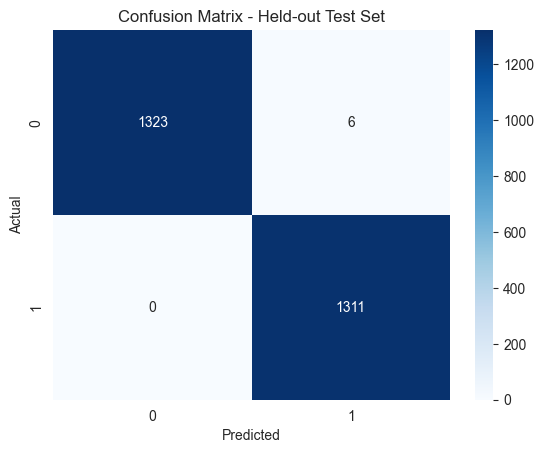

In [19]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Held-out Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## CM Logreg

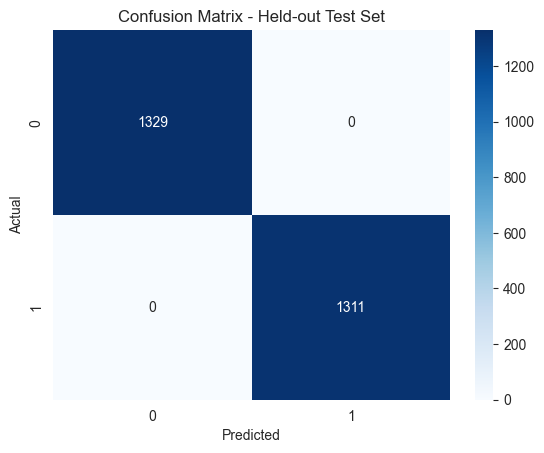

In [22]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Held-out Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()